# (A) Dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

# (B) Dataset

### Downloading the dataset via kaggle api
- [Dataset Source](https://www.kaggle.com/datasets/soumikrakshit/anime-faces)

In [2]:
# Download kaggle api
!pip install -q kaggle

In [3]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- Upload your kaggle token
- For creating a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [4]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [5]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [6]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d soumikrakshit/anime-faces

 96% 424M/441M [00:04<00:00, 114MB/s] 
100% 441M/441M [00:04<00:00, 97.0MB/s]


In [8]:
!unzip anime-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       

In [9]:
!ls

anime-faces.zip  data  sample_data


## Loading the dataset

In [10]:
dataset_dir = 'data'

batch_size = 64

In [11]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=(64, 64),
    batch_size=batch_size,
)

Found 21551 files belonging to 1 classes.


## Displaying the images

In [12]:
dataset.class_names

['data']

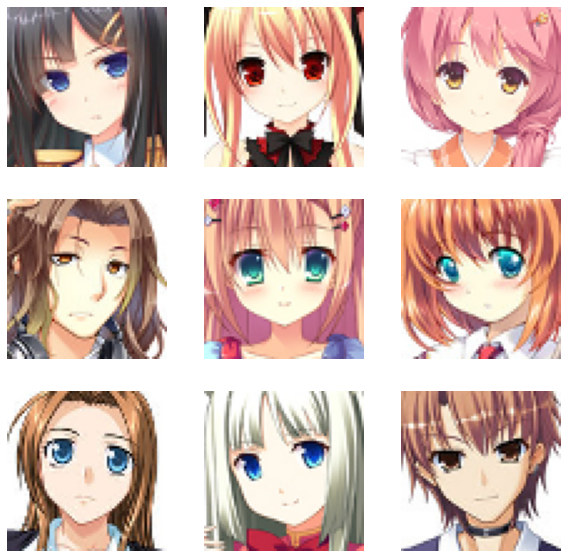

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(1):
  for i in range(9):
    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# (C) Preprocessing

In [14]:
img_height, img_width = 64,64
AUTOTUNE = tf.data.AUTOTUNE

## Pre-processes

In [15]:
def pre_processing(image, label, is_resize=True , new_size=(64,64)):
  
  # Cast the image to tf.float32
  image = tf.cast(image, tf.float32)

  if is_resize:
    # resizing the image
    image = tf.image.resize(image, new_size)

  # scaling the images
  #image = tf.keras.layers.Rescaling(1./255)(image)
  #image /= 255.0
  image = (image - 127.5) / 127.5
  image = tf.cast(image, tf.float32)
  
  return image, label

In [16]:
def de_mormalize(image):
  return (image*127.5) + 127.5

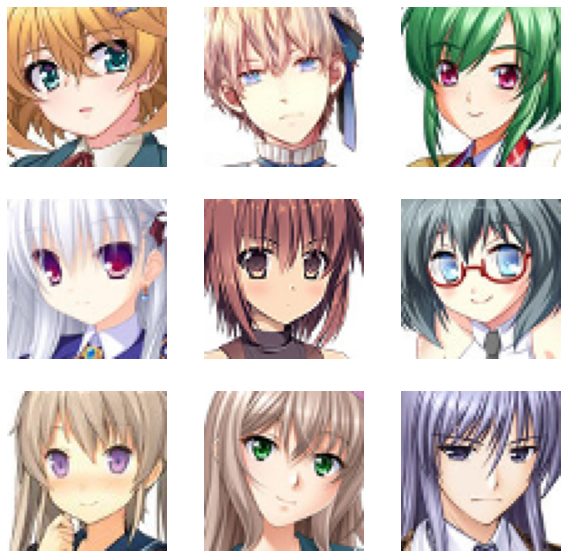

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(1):
  for i in range(9):
    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## Data Augmentation

In [20]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential(
  [
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2),
    #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.GaussianNoise(0.1),
    #layers.CenterCrop(height=224, width=224),
    #layers.Rescaling(1./255),
    #layers.Normalization(mean=[0.485, 0.456, 0.406], stddev=[0.229, 0.224, 0.225]),
  ]
)

## visualizating the data augmentation

##### util functions

In [21]:
def augment_multiple(sample_data, aug_size = 8, figsize=(30,30), is_processed=False):
  rs, cs = len(sample_data), aug_size+1
  plt.figure(figsize=figsize)

  for row_id, image in enumerate(sample_data):
    # extracting the image
    image, _ =  pre_processing(image, 0) if not is_processed else (image, 0 )


    # plotting the original image in the first axis
    first_col_on_cur_row = row_id*cs + 1
    plt.subplot(rs, cs , first_col_on_cur_row)
    plt.imshow(np.uint8(image)) # astype("uint8"),
    plt.title(f"Original Image")
    plt.axis("off")


    for col_id in range(1, cs):
        
        # augmenting same image 
        data = {"image":np.array(image)}
        aug_img = data_augmentation(image)
        # plotting 
        cur_col = first_col_on_cur_row + col_id 
        plt.subplot(rs, cs ,  cur_col)
        plt.imshow(np.uint8(aug_img))
        plt.axis("off")
        

In [22]:
# Getting the sample data to futher usage
if not os.path.exists("samples"):os.mkdir("samples")
for img_path in os.listdir("data")[:10]:
  os.system(f"cp  data/{img_path}  samples/")

In [23]:
sample_paths = [os.path.join("samples", img_path) for img_path in  os.listdir("samples")]
sample_paths

['samples/6501.png',
 'samples/12616.png',
 'samples/5924.png',
 'samples/1029.png',
 'samples/10841.png',
 'samples/15485.png',
 'samples/10119.png',
 'samples/17300.png',
 'samples/17735.png',
 'samples/10947.png']

##### Demostration

In [24]:
import cv2

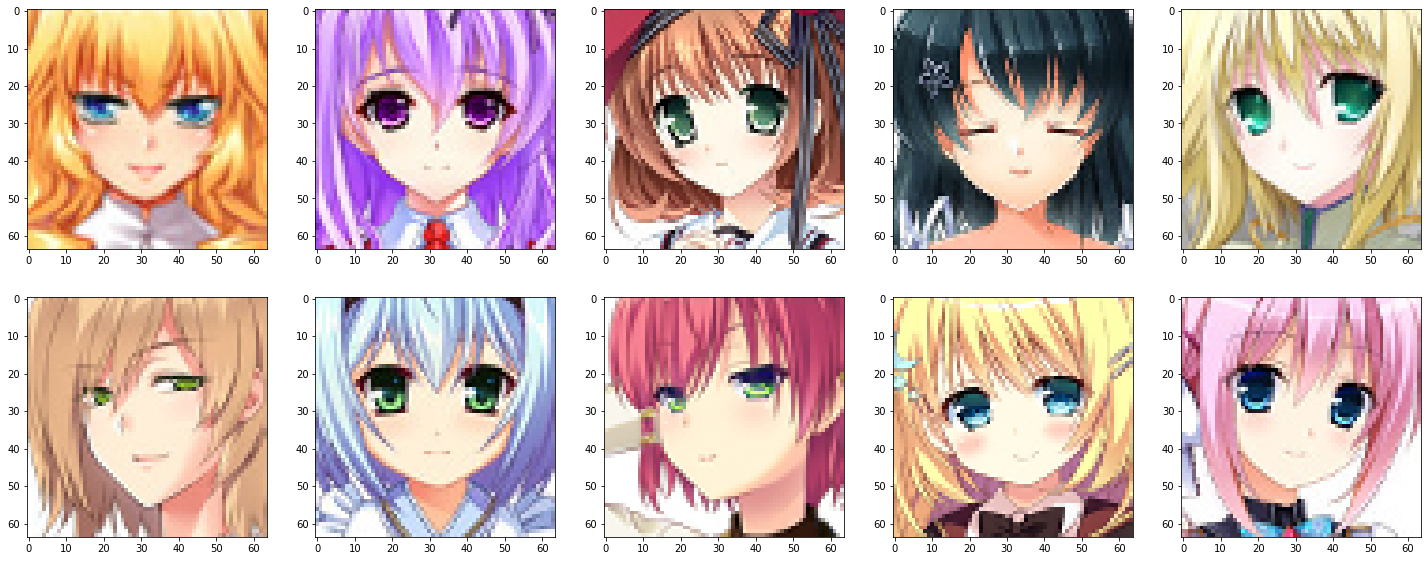

In [25]:
rs, cs = len(sample_paths)//5+1, 5
plt.figure(figsize=(cs*5, rs*5))
loaded_samples = []
for i, img_path in enumerate(sample_paths):
  
  # Reading the image as rgb instead of bgr (default cv2 reading)
  img = cv2.imread(img_path)[...,::-1]
  loaded_samples.append(img)

  # plotting the image
  plt.subplot(rs, cs, i+1)
  plt.imshow(img)


In [ ]:
os.system(f"zip -r samples.zip samples")

0

In [ ]:
from google.colab import files
files.download("samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

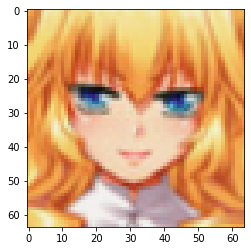

In [26]:
ex = data_augmentation(np.expand_dims(loaded_samples[0],axis=0))[0]
plt.imshow(np.uint8(ex))

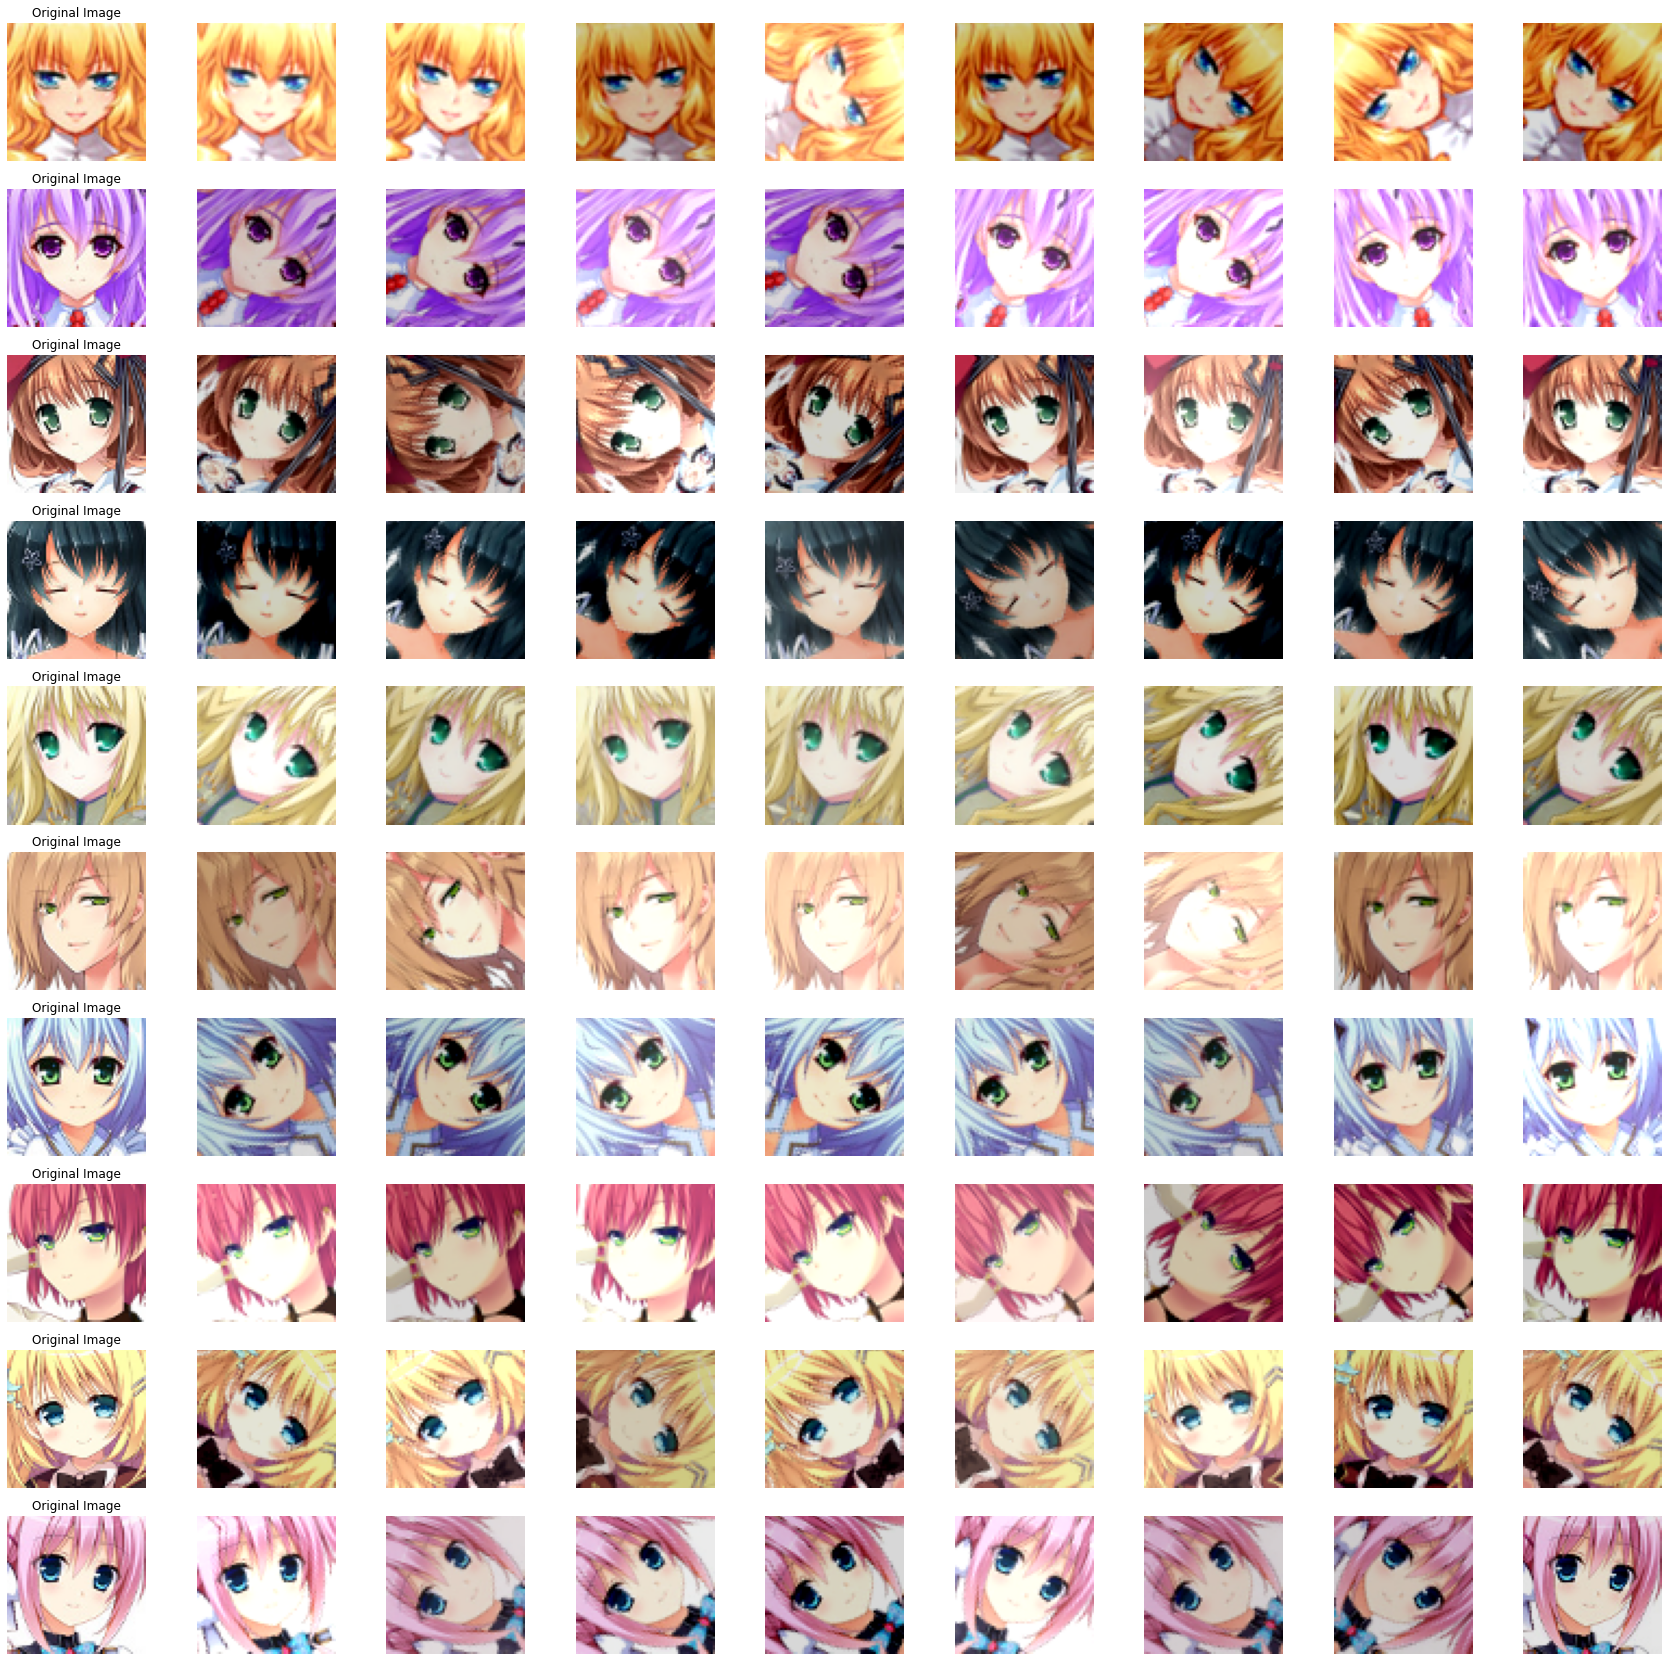

In [27]:
augment_multiple(loaded_samples, is_processed=True);

## Implementing the processes

### Initial

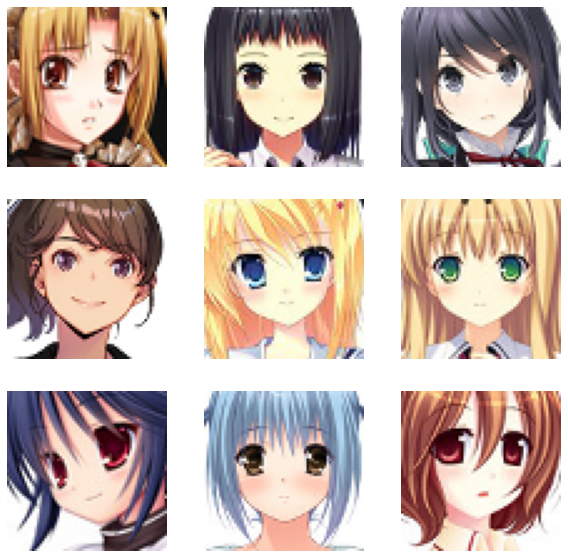

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(1):
  for i in range(9):
    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Augmentation

In [30]:
#train_ds_spare= train_ds

In [31]:
dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [32]:
dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

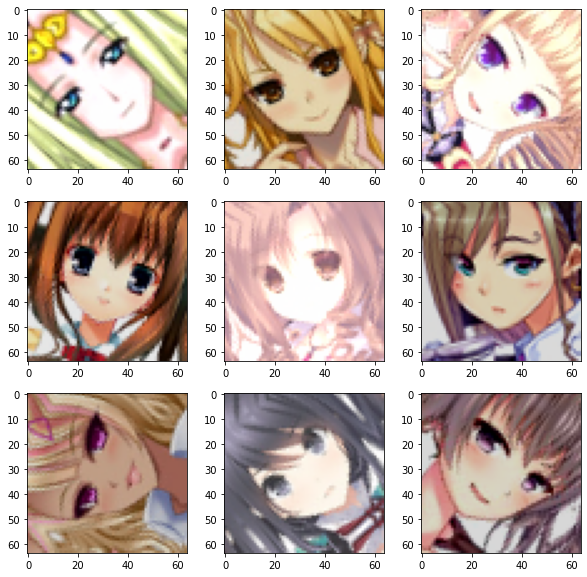

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, _) in enumerate(dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    #plt.imshow(de_mormalize(image)) 


### Preprocessing

In [35]:
# Pre-processing the data
dataset = dataset.map(pre_processing)

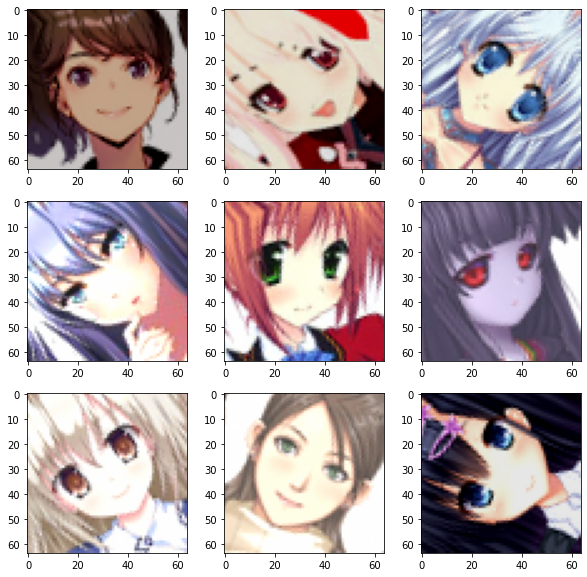

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, _) in enumerate(dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(de_mormalize(image).numpy().astype("uint8"))
    #plt.imshow(de_mormalize(image)) 


### Performance Configuration 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# processing the dataset & performance configuration
dataset = dataset.shuffle(len(dataset)).cache().prefetch(AUTOTUNE)

In [ ]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# (D) Modelling

## Architecture

In [ ]:
#Configurations
LATENT_DIM = 100
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 3 

### Generator Model


In [ ]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

### Discriminator Model

Discriminator model will classify the image from the generator to check whether it real (or) fake images.

In [ ]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

### Model Architecture

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')


    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
                
        # generate random noise
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            
            # discriminator (pred then loss)
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # generator (generate then implemen discriminator steps again)
            fake_images = self.generator(random_noise)

            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients then update the gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            
            # generate then implement discriminator
            fake_images = self.generator(random_noise, training=True)

            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients then update the gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
# Custom Callback to display image per every train step
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        # plot the image per step
        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Building a model

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001 
G_LR = 0.0003
comp_params = {
    "g_optimizer":Adam(learning_rate=G_LR, beta_1=0.5),
    "d_optimizer":Adam(learning_rate=D_LR, beta_1=0.5),
    "loss_fn":BinaryCrossentropy()
}
dcgan.compile(**comp_params)

## Training

In [ ]:
#dataset = dataset.map(lambda x,_: tf.cast(x, tf.float32))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "GenModel"
tb_log_dir = "./logs"

In [ ]:
callbacks = [
    #LearningRateScheduler(step_decay),
    DCGANMonitor(),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

In [ ]:
N_EPOCHS = 50
history = dcgan.fit(dataset, epochs=N_EPOCHS, callbacks=callbacks)

## Prediction

In [ ]:
# creating the noise
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.0395542e+00,  4.7797483e-01, -1.3400197e-03, -6.0218799e-01,
        -1.8374655e+00, -1.0466620e+00, -4.4103023e-01, -1.8136674e-01,
        -1.0923326e+00,  7.7846003e-01, -1.8669460e+00,  1.4214914e+00,
         1.2223101e+00,  4.0458074e-01, -2.6868334e-01,  7.3034155e-01,
        -1.4181544e+00,  1.2000271e-01,  1.8928481e+00,  1.5558913e-01,
         1.9448020e+00,  1.4584774e-01,  2.5725168e-01,  1.1228403e+00,
         1.0795542e-01,  1.6520934e+00,  4.9441901e-01,  8.7071592e-01,
        -3.3714211e-01,  7.4926227e-01,  9.1504484e-02, -2.3358519e-01,
        -1.6249480e+00, -1.0362414e+00, -1.8294560e+00,  1.1017982e+00,
        -2.9743893e-02, -5.8472633e-01,  2.2013295e+00,  8.5656297e-01,
         2.1426053e-01, -5.9921271e-01,  3.8149226e-01, -1.9566527e-02,
        -7.0341676e-01, -1.8295857e+00,  1.5788805e+00, -3.5687202e-01,
         2.1375754e+00,  6.0725804e-02, -3.1294605e-01, -1.4540098e+00,
        -1.315

In [ ]:
# generating the iamge
g_img = dcgan.generator(noise)

# adjusting the iamge
g_img = (g_img * 127.5) + 127.5
img = array_to_img(g_img.numpy()[0])

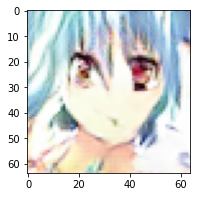

In [ ]:
# plotting the result image
fig = plt.figure(figsize=(3, 3))
plt.imshow(img)

# (E) Save the model

In [ ]:
# Load the best weights
#model.load_weights(checkpoint_path)

In [ ]:
# Define the path where you want to save the weights
weights_save_path = "GANModel_Weights/DCGAN_weights"

# Save the weights
dcgan.save_weights(weights_save_path)

In [ ]:
dcgan_spare = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001 
G_LR = 0.0003
comp_params = {
    "g_optimizer":Adam(learning_rate=G_LR, beta_1=0.5),
    "d_optimizer":Adam(learning_rate=D_LR, beta_1=0.5),
    "loss_fn":BinaryCrossentropy()
}
dcgan_spare.compile(**comp_params)

In [ ]:
dcgan_spare.load_weights(weights_save_path)

In [ ]:
!zip -r GANModel_Weights.zip GANModel_Weights/

updating: GANModel_Weights/ (stored 0%)
  adding: GANModel_Weights/DCGAN_weights.index (deflated 70%)
  adding: GANModel_Weights/DCGAN_weights.data-00000-of-00001 (deflated 9%)
  adding: GANModel_Weights/checkpoint (deflated 39%)


In [ ]:
!cp -r /content/GANModel_Weights /content/drive/MyDrive/Home/Projects/[ImageGenerator]AnimeFaceGeneration

In [ ]:
from datetime import datetime
best_model_save_path = "DCGANModel_second_train" 
#dcgan.save(best_model_save_path)

In [ ]:
#loaded_model = tf.keras.models.load_model('/content/DCGANModel')

In [ ]:
# Zipping the model to download
dst, src = f"{best_model_save_path}.zip", best_model_save_path
os.system(f"zip -r {dst} {src}")

0

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (F) Demo App

In [37]:
import os
if os.system("pip freeze | greb gradio")!=0:os.system("pip install gradio")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.system(f"cp -r /content/drive/MyDrive/Home/Projects/[ImageGenerator]AnimeFaceGeneration/GANModel_Weights GANModel_Weights")

In [ ]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model

In [ ]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')


    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
                
        # generate random noise
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            
            # discriminator (pred then loss)
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # generator (generate then implemen discriminator steps again)
            fake_images = self.generator(random_noise)

            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients then update the gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            
            # generate then implement discriminator
            fake_images = self.generator(random_noise, training=True)

            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients then update the gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
#!unzip BasicModel.zip

In [ ]:
import gradio as gr
import tensorflow as tf
from glob import glob
import cv2
import os
import numpy as np

In [ ]:
model_weights  = "GANModel_Weights/DCGAN_weights"
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

D_LR = 0.0001 
G_LR = 0.0003
comp_params = {
    "g_optimizer":Adam(learning_rate=G_LR, beta_1=0.5),
    "d_optimizer":Adam(learning_rate=D_LR, beta_1=0.5),
    "loss_fn":BinaryCrossentropy()
}
dcgan.compile(**comp_params)

dcgan.load_weights(model_weights)

In [ ]:
def generate():

    noise = tf.random.normal([1, 100])
    
    # generate the image from noise
    g_img = dcgan.generator(noise)
    
    # denormalize the image
    g_img = (g_img * 127.5) + 127.5
    
    # adjusting the image
    g_img.numpy()
    img = array_to_img(g_img[0])

    return img

In [ ]:
gr.Interface(fn=generate, inputs=None,outputs=gr.Image()).launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>